# 은행 이탈 데이터 셋을 이용한 이진 분류
Binary Classification with a Bank Churn Dataset

---

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder 
import missingno as mno
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV
import time

# 2. 데이터 탐색 및 전처리
- train 데이터 컬럼
    - id: ID
    - CustomerId: 고객ID
    - Surname: 성(이름)
    - CreditScore: 신용점수
    - Geography: 지역(국가)
    - Gender: 성별
    - Age: 나이
    - Tenure: 가입기간
    - Balance: 잔액
    - NumOfProducts: 고객 보유 상품 수
    - HasCrCard: 신용카드 유무 (1: Yes, 0: No)
    - IsActiveMember: 활성 멤버쉽 (1: Yes, 0: No)
    - EstimatedSalary: 예상 급여
    - Exited: 이탈 유무(1: Yes, 0: No) => 타겟 컬럼

In [3]:
# 데이터 불러오기(train, test, submission)
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
submission = pd.read_csv('./data/sample_submission.csv')

In [4]:
train.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [5]:
test.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,165034,15773898,Lucchese,586,France,Female,23.0,2,0.00,2,0.0,1.0,160976.75
1,165035,15782418,Nott,683,France,Female,46.0,2,0.00,1,1.0,0.0,72549.27
2,165036,15807120,K?,656,France,Female,34.0,7,0.00,2,1.0,0.0,138882.09
3,165037,15808905,O'Donnell,681,France,Male,36.0,8,0.00,1,1.0,0.0,113931.57
4,165038,15607314,Higgins,752,Germany,Male,38.0,10,121263.62,1,1.0,0.0,139431.00


In [6]:
# 불필요한 컬럼 삭제
train.drop(['id', 'Surname'], axis=1, inplace=True)
test.drop(['id', 'Surname'], axis=1, inplace=True)

In [7]:
train.columns

Index(['CustomerId', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure',
       'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember',
       'EstimatedSalary', 'Exited'],
      dtype='object')

In [8]:
test.columns

Index(['CustomerId', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure',
       'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember',
       'EstimatedSalary'],
      dtype='object')

In [9]:
# train 데이터 null값 확인
train.isnull().sum()

CustomerId         0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

<Axes: >

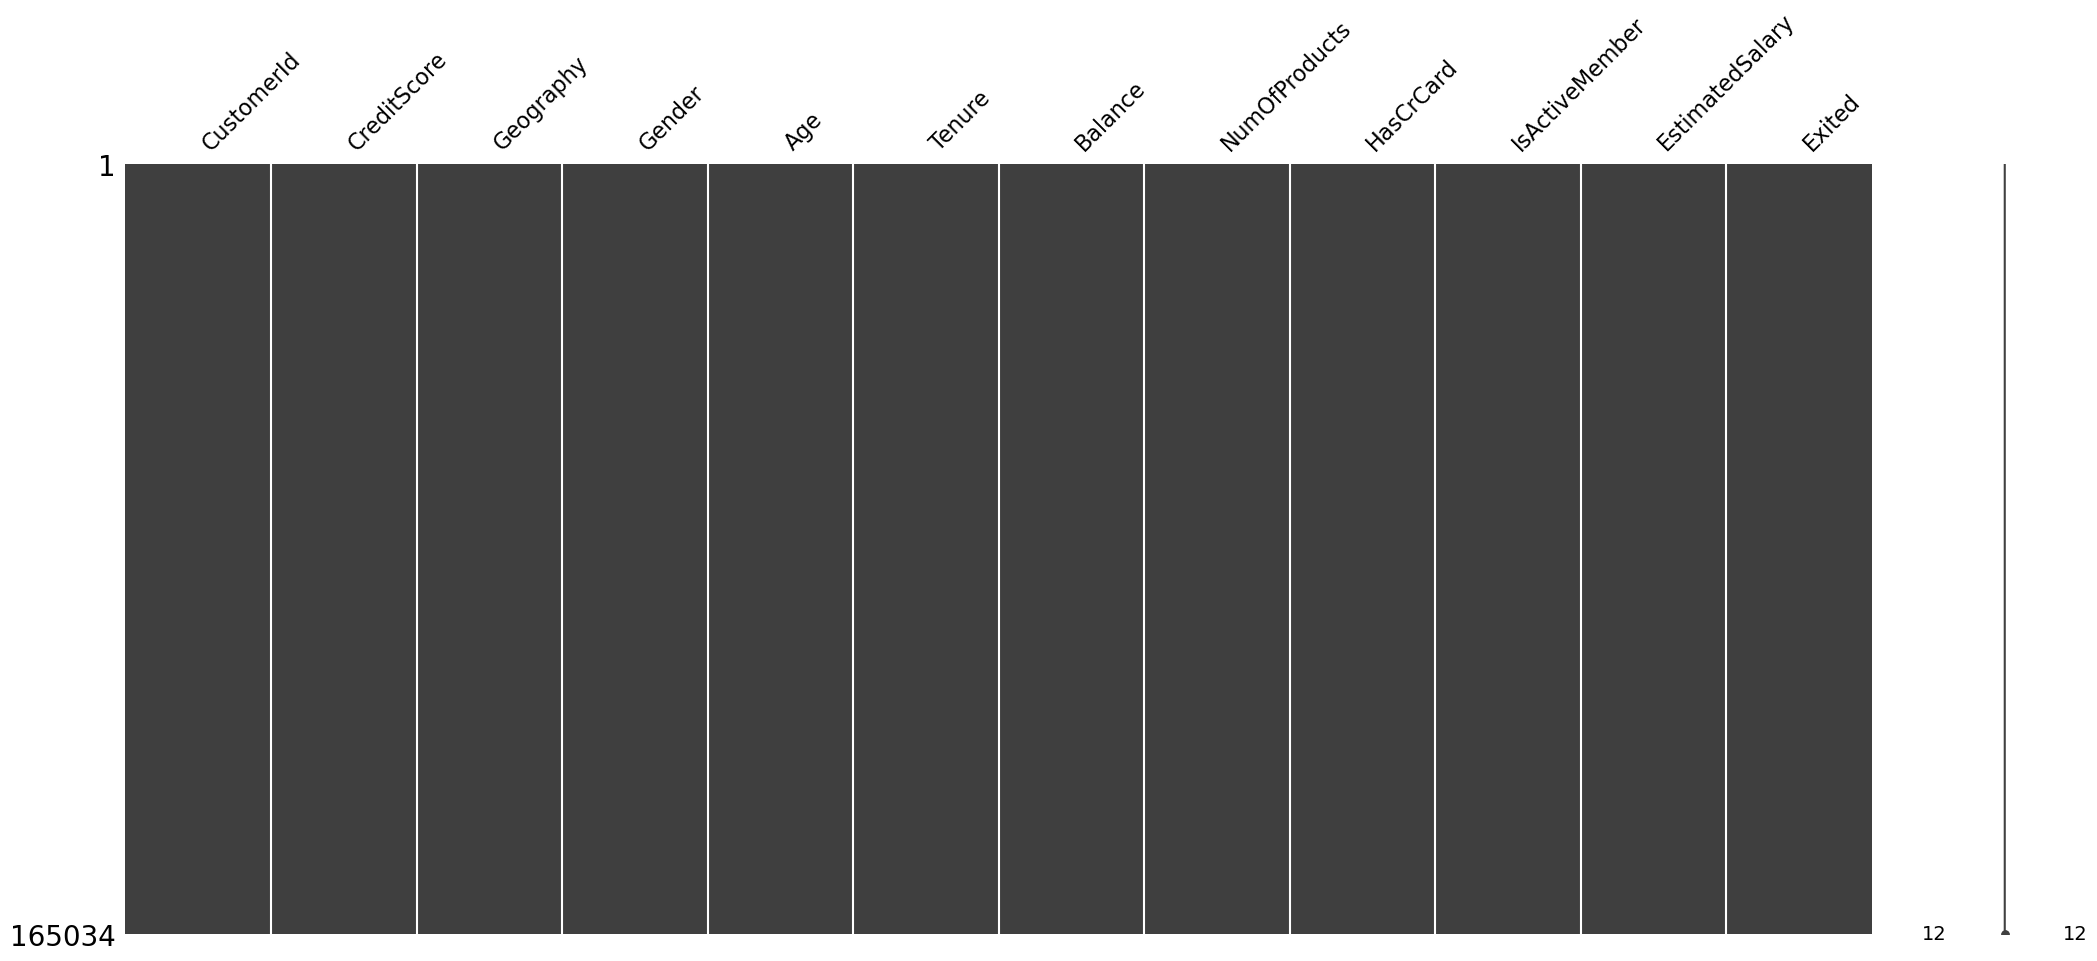

In [10]:
mno.matrix(train)


In [11]:
# test 데이터 null값 확인
test.isnull().sum()

CustomerId         0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
dtype: int64

<Axes: >

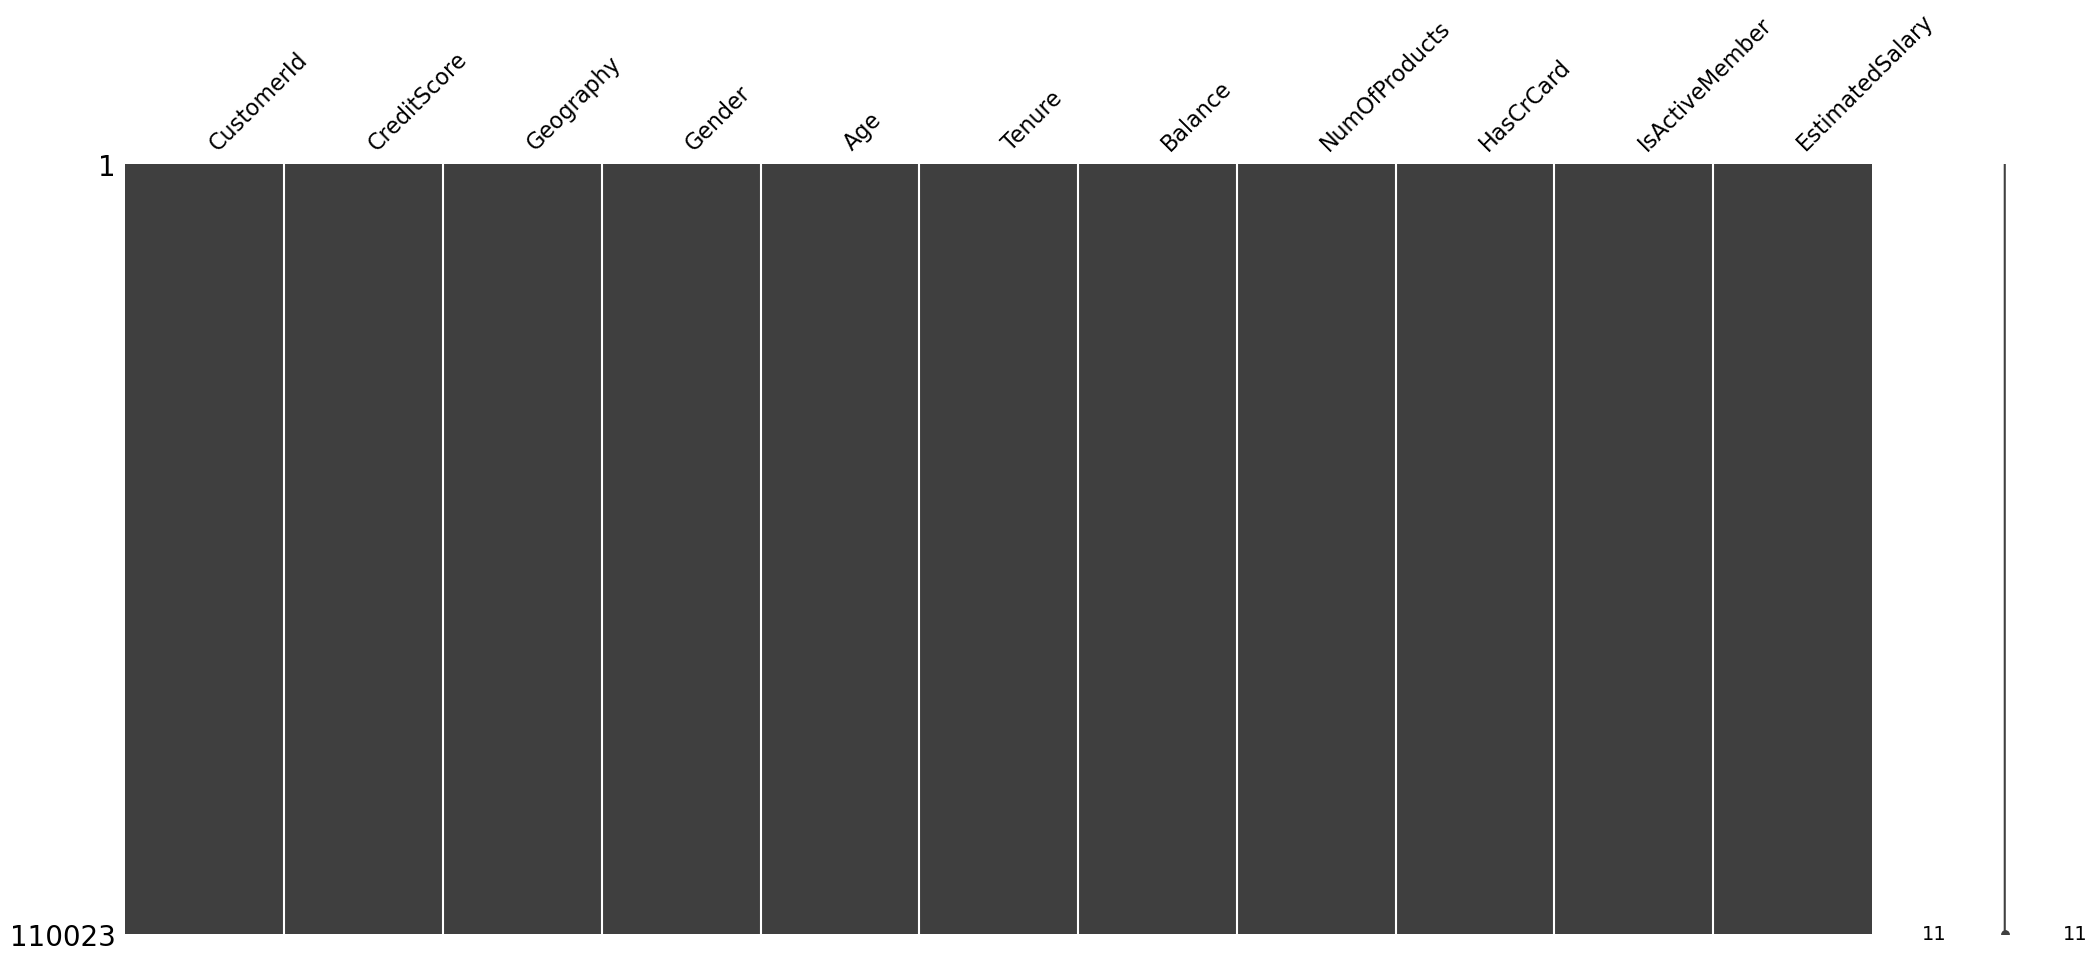

In [12]:
mno.matrix(test)


In [13]:
# train 데이터 중복값 제거
train.duplicated().sum()

30

In [14]:
train.drop_duplicates(inplace=True)

In [15]:
train.duplicated().sum()

0

In [16]:
# test 데이터 중복값 제거
test.duplicated().sum()

19

In [17]:
test.drop_duplicates(inplace=True)
test.duplicated().sum()

0

In [18]:
# train / test 데이터 크기 조회
train.shape

(165004, 12)

In [19]:
test.shape

(110004, 11)

In [20]:
# train / test 데이터 크기 및 비율 조회
print(f'Train data : {train.shape}')
print(f'Test data : {test.shape}')

train_data_percentage = np.round(train.shape[0] / (train.shape[0] + test.shape[0]), 4)
print(f'Train data Percentage : {train_data_percentage * 100}%')
print(f'Test data Percentage : {(1- train_data_percentage) * 100}%')

Train data : (165004, 12)
Test data : (110004, 11)
Train data Percentage : 60.0%
Test data Percentage : 40.0%


In [21]:
# train 데이터 통계적 수치 확인
train.describe().T

,count,mean,std,min,25%,50%,75%,max
CustomerId,165004.0,1.569200e+07,71398.294444,15565701.00,1.563312e+07,15690165.5,15756824.00,15815690.00
CreditScore,165004.0,6.564580e+02,80.101397,350.00,5.970000e+02,659.0,710.00,850.00
Age,165004.0,3.812536e+01,8.866923,18.00,3.200000e+01,37.0,42.00,92.00
Tenure,165004.0,5.020515e+00,2.806134,0.00,3.000000e+00,5.0,7.00,10.00
Balance,165004.0,5.547720e+04,62817.816773,0.00,0.000000e+00,0.0,119948.09,250898.09
NumOfProducts,165004.0,1.554465e+00,0.547161,1.00,1.000000e+00,2.0,2.00,4.00
HasCrCard,165004.0,7.539332e-01,0.430719,0.00,1.000000e+00,1.0,1.00,1.00
IsActiveMember,165004.0,4.977394e-01,0.499996,0.00,0.000000e+00,0.0,1.00,1.00
EstimatedSalary,165004.0,1.125762e+05,50293.024195,11.58,7.463765e+04,117948.0,155155.25,199992.48
Exited,165004.0,2.116009e-01,0.408445,0.00,0.000000e+00,0.0,0.00,1.00


In [22]:
# Train 데이터 형식 확인
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 165004 entries, 0 to 165033
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CustomerId       165004 non-null  int64  
 1   CreditScore      165004 non-null  int64  
 2   Geography        165004 non-null  object 
 3   Gender           165004 non-null  object 
 4   Age              165004 non-null  float64
 5   Tenure           165004 non-null  int64  
 6   Balance          165004 non-null  float64
 7   NumOfProducts    165004 non-null  int64  
 8   HasCrCard        165004 non-null  float64
 9   IsActiveMember   165004 non-null  float64
 10  EstimatedSalary  165004 non-null  float64
 11  Exited           165004 non-null  int64  
dtypes: float64(5), int64(5), object(2)
memory usage: 16.4+ MB


In [23]:
# 문자열 데이터인 Geography와 Gender 상세 개수 확인
train.Geography.value_counts()

Geography
France     94193
Spain      36209
Germany    34602
Name: count, dtype: int64

In [24]:
train.Gender.value_counts()

Gender
Male      93134
Female    71870
Name: count, dtype: int64

---

# 4. Encoding

In [25]:
# one-hot encoding
train_encoding = pd.get_dummies(train, columns=['Geography', 'Gender'])
train_encoding.head()

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,15674932,668,33.0,3,0.00,2,1.0,0.0,181449.97,0,True,False,False,False,True
1,15749177,627,33.0,1,0.00,2,1.0,1.0,49503.50,0,True,False,False,False,True
2,15694510,678,40.0,10,0.00,2,1.0,0.0,184866.69,0,True,False,False,False,True
3,15741417,581,34.0,2,148882.54,1,1.0,1.0,84560.88,0,True,False,False,False,True
4,15766172,716,33.0,5,0.00,2,1.0,1.0,15068.83,0,False,False,True,False,True


---

# 5. Modeling
- Logistic Regression
- Decision Tree
- Random Forest
- LightBGM
- XGBoost
- CatBoost (추후 추가 예정)

In [26]:
# X, y 데이터 설정
X = train_encoding.drop(['Exited', 'CustomerId'], axis=1)
y = train_encoding['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)
X.shape, y.shape

((165004, 13), (165004,))

In [27]:
# 나눈 데이터의 불균형 정도 확인

print(np.unique(y_train, return_counts=True)[1][1] / len(y_train) * 100, '%')

21.12906524851708 %


In [28]:
# over sampling
smote = SMOTE(random_state=13)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

In [29]:
print(X_train.shape, y_train.shape)
print(X_train_over.shape, y_train_over.shape)

(132003, 13) (132003,)
(208224, 13) (208224,)


---

# 함수 정의

In [43]:
# 성능 지표 함수
def print_clf_eval(y_test, pred, pred_proba):

    start_time = time.time()

    acc = accuracy_score(y_test, pred)
    pre = precision_score(y_test, pred)
    re = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    auc = roc_auc_score(y_test, pred_proba)

    confusion = confusion_matrix(y_test, pred)

    print('==> Confusion matrix')
    print(confusion)
    print('====================')

    print('Accuracy : {0:.4f}, Precision : {1:.4f}'.format(acc, pre)) # :.4f는 소수점 4째자리까지 표현하라는 뜻
    print('Recall : {0:.4f}, F1 : {1:.4f}, AUC : {2:.4f}'.format(re, f1, auc))
    print('Fit time : ', time.time() - start_time)
    print()

    return acc, pre, re, f1, auc

In [44]:
# 모델과 데이터를 주면 성능을 출력하는 함수
def get_result(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    pred_proba = model.predict_proba(X_test)[:, 1]

    return print_clf_eval(y_test, pred, pred_proba)

In [45]:
# 다수의 모델의 성능을 정리해서 DataFrame으로 반환하는 함수
def get_result_pd(models, model_names, X_train, y_train, X_test, y_test):
    col_names = ['Accuracy', 'Precision',  'Recall',  'F1',  'Roc_Auc']
    tmp = []

    for model in models:
        tmp.append(get_result(model, X_train, y_train, X_test, y_test))

    return pd.DataFrame(tmp, columns=col_names, index=model_names)

In [ ]:
# 모델별 roc 커브 그리기
def draw_roc_curve(models, model_names, X_test, y_test):
    plt.figure(figsize=(10, 10))

    for model in range(len(models)):
        pred = models[model].predict_proba(X_test)[:, 1] 
        fpr, tpr, thresholds = roc_curve(y_test, pred)
        plt.plot(fpr, tpr, label=model_names[model])

    plt.plot([0, 1],[0, 1], 'k--', label='random guess') 
    plt.title('ROC')
    plt.legend()
    plt.grid()
    plt.show()

---

# Logistic Regression


In [63]:
# class_weight + over sampling
lr = LogisticRegression(random_state=13, class_weight='balanced')
lr.fit(X_train_over, y_train_over)
lr_proba = lr.predict_proba(X_test)
lr_pred = lr.predict(X_test)

print_clf_eval(y_test, lr_pred, lr_proba[:, 1])

==> Confusion matrix
[[18038  7939]
 [ 2273  4751]]
Accuracy : 0.6906, Precision : 0.3744
Recall : 0.6764, F1 : 0.4820, AUC : 0.7350
Fit time :  0.08470988273620605



(0.6905548316717676,
 0.3743892828999212,
 0.6763952164009112,
 0.4819924926448209,
 0.7350215837288339)

In [87]:
# class_weight
lr = LogisticRegression(random_state=13, class_weight='balanced')
lr.fit(X_train, y_train)
lr_proba = lr.predict_proba(X_test)
lr_pred = lr.predict(X_test)

print_clf_eval(y_test, lr_pred, lr_proba[:, 1])

==> Confusion matrix
[[18258  7719]
 [ 2164  4860]]
Accuracy : 0.7005, Precision : 0.3864
Recall : 0.6919, F1 : 0.4958, AUC : 0.7538
Fit time :  0.08377456665039062



(0.7005242265385897,
 0.38635821607440973,
 0.6919134396355353,
 0.4958424730908535,
 0.753820427203739)

# Decision Tree

In [60]:
# class_weight + over sampling
lr = DecisionTreeClassifier(class_weight='balanced', max_depth=3)
lr.fit(X_train_over, y_train_over)
lr_proba = lr.predict_proba(X_test)
lr_pred = lr.predict(X_test)

print_clf_eval(y_test, lr_pred, lr_proba[:, 1])

==> Confusion matrix
[[20149  5828]
 [ 1612  5412]]
Accuracy : 0.7746, Precision : 0.4815
Recall : 0.7705, F1 : 0.5926, AUC : 0.8432
Fit time :  0.05909228324890137



(0.7745522862943547,
 0.4814946619217082,
 0.770501138952164,
 0.592641261498029,
 0.843233680061116)

In [88]:
# class_weight
lr = DecisionTreeClassifier(class_weight='balanced', max_depth=3)
lr.fit(X_train, y_train)
lr_proba = lr.predict_proba(X_test)
lr_pred = lr.predict(X_test)

print_clf_eval(y_test, lr_pred, lr_proba[:, 1])

==> Confusion matrix
[[20149  5828]
 [ 1612  5412]]
Accuracy : 0.7746, Precision : 0.4815
Recall : 0.7705, F1 : 0.5926, AUC : 0.8435
Fit time :  0.0578463077545166



(0.7745522862943547,
 0.4814946619217082,
 0.770501138952164,
 0.592641261498029,
 0.8434745953863338)

# Random Forest

In [49]:
# class_weight + over sampling
# max_depth 포함
rf = RandomForestClassifier(random_state=13, max_depth=3, class_weight='balanced')
rf.fit(X_train_over, y_train_over)
rf_proba = rf.predict_proba(X_test)
rf_pred = rf.predict(X_test)

print_clf_eval(y_test, rf_pred, rf_proba[:, 1])

==> Confusion matrix
[[21911  4066]
 [ 2280  4744]]
Accuracy : 0.8077, Precision : 0.5385
Recall : 0.6754, F1 : 0.5992, AUC : 0.8529
Fit time :  0.15575242042541504



(0.8077027968849428,
 0.5384790011350737,
 0.6753986332574032,
 0.5992168750789441,
 0.8529341555255249)

In [89]:
# class_weight
# max_depth 포함
rf = RandomForestClassifier(random_state=13, max_depth=3, class_weight='balanced')
rf.fit(X_train, y_train)
rf_proba = rf.predict_proba(X_test)
rf_pred = rf.predict(X_test)

print_clf_eval(y_test, rf_pred, rf_proba[:, 1])

==> Confusion matrix
[[20467  5510]
 [ 1673  5351]]
Accuracy : 0.7823, Precision : 0.4927
Recall : 0.7618, F1 : 0.5984, AUC : 0.8551
Fit time :  0.06283950805664062



(0.7823399290930578,
 0.492680232022834,
 0.7618166287015945,
 0.5983785294939894,
 0.8551063339893369)

# LightGBM

In [50]:
# class_weight + over sampling
lgbm = LGBMClassifier(random_state=13, max_depth=3, class_weight='balanced')
lgbm.fit(X_train_over, y_train_over)
lgbm_proba = lgbm.predict_proba(X_test)
lgbm_pred = lgbm.predict(X_test)

print_clf_eval(y_test, lgbm_pred, lgbm_proba[:, 1])

[LightGBM] [Info] Number of positive: 104112, number of negative: 104112
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010124 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1556
[LightGBM] [Info] Number of data points in the train set: 208224, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
==> Confusion matrix
[[23970  2007]
 [ 2651  4373]]
Accuracy : 0.8589, Precision : 0.6854
Recall : 0.6226, F1 : 0.6525, AUC : 0.8856
Fit time :  0.11377382278442383



(0.858852762037514,
 0.685423197492163,
 0.6225797266514806,
 0.6524917934944794,
 0.8856144799723392)

In [90]:
# class_weight
lgbm = LGBMClassifier(random_state=13, max_depth=3, class_weight='balanced')
lgbm.fit(X_train, y_train)
lgbm_proba = lgbm.predict_proba(X_test)
lgbm_pred = lgbm.predict(X_test)

print_clf_eval(y_test, lgbm_pred, lgbm_proba[:, 1])

[LightGBM] [Info] Number of positive: 27891, number of negative: 104112
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018505 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 863
[LightGBM] [Info] Number of data points in the train set: 132003, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
==> Confusion matrix
[[21085  4892]
 [ 1417  5607]]
Accuracy : 0.8088, Precision : 0.5341
Recall : 0.7983, F1 : 0.6400, AUC : 0.8869
Fit time :  0.07679367065429688



(0.8088239750310596,
 0.5340508619868559,
 0.7982630979498861,
 0.6399589111453517,
 0.8868923264692798)

# XGBoost

In [92]:
# over sampling
scale_pos_weight = y_train_over.value_counts()[0] / y_train_over.value_counts()[1]
xgb = XGBClassifier(random_state=13, max_depth=3, scale_pos_weight=scale_pos_weight)
xgb.fit(X_train_over, y_train_over)
xgb_proba = xgb.predict_proba(X_test)
xgb_pred = xgb.predict(X_test)

print_clf_eval(y_test, xgb_pred, xgb_proba[:, 1])

c:\Users\User\miniconda3\envs\ds_study\lib\site-packages\xgboost\core.py:160: UserWarning: [09:25:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


==> Confusion matrix
[[24298  1679]
 [ 2848  4176]]
Accuracy : 0.8628, Precision : 0.7132
Recall : 0.5945, F1 : 0.6485, AUC : 0.8873
Fit time :  0.11369776725769043



(0.8628223387170085,
 0.7132365499573015,
 0.5945330296127562,
 0.6484975541579315,
 0.8872819107414365)

# 결과:

- max_depth를 추가하는게 recall 성능이 더 높음
- XGB에는 class weight 파라미터 사용하지 않음
- Decision tree를 제외하고 나머지 모델들은 oversampling을 사용하지 않고 class weight만 포함시킨 모델링의 recall이 더 높았음

# CatBoost

In [ ]:
## 추후 추가

# 성능 평가표

### 1. class weight + over sampling

In [68]:
# 6개의 분류 모델을 한번에 표로 정리
lr_clf = LogisticRegression(random_state=13, solver='liblinear', class_weight='balanced')
dt_clf = DecisionTreeClassifier(random_state=13, max_depth=3, class_weight='balanced')
rf_clf = RandomForestClassifier(random_state=13, max_depth=3, class_weight='balanced')
lgbm_clf = LGBMClassifier(random_state=13, max_depth=3, class_weight='balanced', boost_from_average=False) 
xgb_clf = XGBClassifier(random_state=13, max_depth=3, scale_pos_weight=scale_pos_weight)
# cat_clf

models = [lr_clf, dt_clf, rf_clf, lgbm_clf, xgb_clf]
model_names = ['LogisticRegression', 'DecisionTree', 'RandomForest', 'LightGBM', 'XGB']
 
result = get_result_pd(models, model_names, X_train_over, y_train_over, X_test, y_test)
result
     

==> Confusion matrix
[[18297  7680]
 [ 2237  4787]]
Accuracy : 0.6995, Precision : 0.3840
Recall : 0.6815, F1 : 0.4912, AUC : 0.7414
Fit time :  0.0778350830078125

==> Confusion matrix
[[20149  5828]
 [ 1612  5412]]
Accuracy : 0.7746, Precision : 0.4815
Recall : 0.7705, F1 : 0.5926, AUC : 0.8432
Fit time :  0.05815243721008301

==> Confusion matrix
[[21911  4066]
 [ 2280  4744]]
Accuracy : 0.8077, Precision : 0.5385
Recall : 0.6754, F1 : 0.5992, AUC : 0.8529
Fit time :  0.09442973136901855

[LightGBM] [Info] Number of positive: 104112, number of negative: 104112
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010364 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1556
[LightGBM] [Info] Number of data points in the train set: 208224, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.0000

,Accuracy,Precision,Recall,F1,Roc_Auc
LogisticRegression,0.699494,0.383974,0.681521,0.491201,0.741414
DecisionTree,0.774552,0.481495,0.770501,0.592641,0.843234
RandomForest,0.807703,0.538479,0.675399,0.599217,0.852934
LightGBM,0.858853,0.685423,0.622580,0.652492,0.885614
XGB,0.862822,0.713237,0.594533,0.648498,0.887282


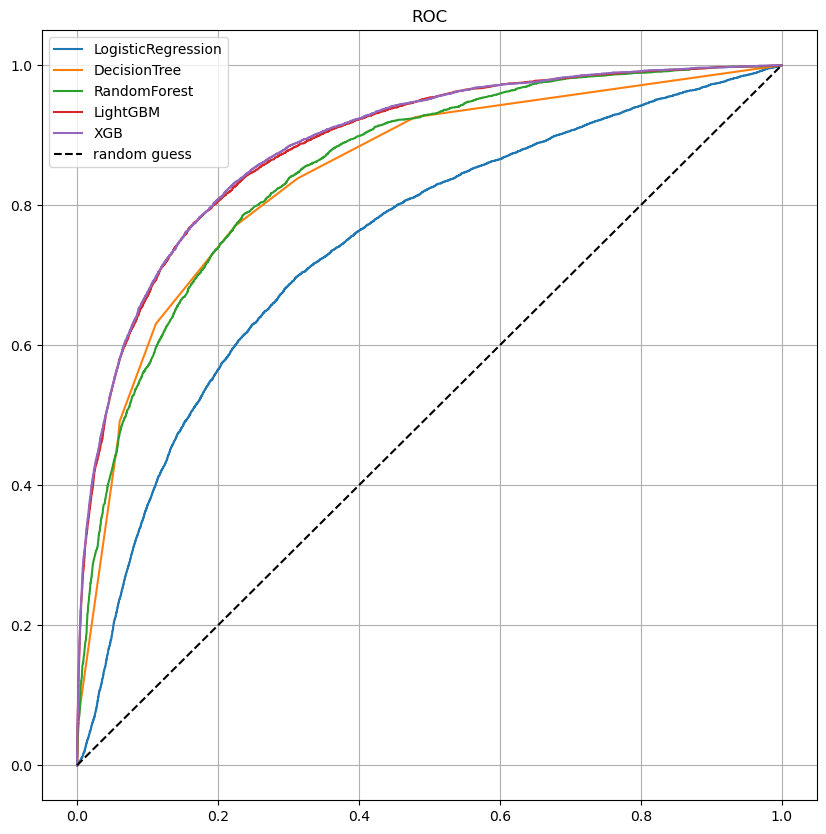

In [66]:
# class weight + over sampling
draw_roc_curve(models, model_names, X_test, y_test)

### 2. class weight

In [94]:
# 6개의 분류 모델을 한번에 표로 정리
lr_clf = LogisticRegression(random_state=13, solver='liblinear', class_weight='balanced')
dt_clf = DecisionTreeClassifier(random_state=13, max_depth=3, class_weight='balanced')
rf_clf = RandomForestClassifier(random_state=13, max_depth=3, class_weight='balanced')
lgbm_clf = LGBMClassifier(random_state=13, max_depth=3, class_weight='balanced', boost_from_average=False) 
xgb_clf = XGBClassifier(random_state=13, max_depth=3, scale_pos_weight=scale_pos_weight)
# cat_clf

models = [lr_clf, dt_clf, rf_clf, lgbm_clf, xgb_clf]
model_names = ['LogisticRegression', 'DecisionTree', 'RandomForest', 'LightGBM', 'XGB']
 
result = get_result_pd(models, model_names, X_train, y_train, X_test, y_test)
result
     

==> Confusion matrix
[[19491  6486]
 [ 1784  5240]]
Accuracy : 0.7494, Precision : 0.4469
Recall : 0.7460, F1 : 0.5589, AUC : 0.8152
Fit time :  0.07579660415649414

==> Confusion matrix
[[20149  5828]
 [ 1612  5412]]
Accuracy : 0.7746, Precision : 0.4815
Recall : 0.7705, F1 : 0.5926, AUC : 0.8435
Fit time :  0.06084275245666504

==> Confusion matrix
[[20467  5510]
 [ 1673  5351]]
Accuracy : 0.7823, Precision : 0.4927
Recall : 0.7618, F1 : 0.5984, AUC : 0.8551
Fit time :  0.09574580192565918

[LightGBM] [Info] Number of positive: 27891, number of negative: 104112
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034917 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 863
[LightGBM] [Info] Number of data points in the train set: 132003, number of used features: 13
==> Confusion matrix
[[21085  4892]
 [ 1417  5607]]
Accuracy : 0.8088, Precision : 0.5341
Recall : 0.7983, F1 : 0.6400, AUC : 0.8869
Fit time

,Accuracy,Precision,Recall,F1,Roc_Auc
LogisticRegression,0.749402,0.446870,0.746014,0.558933,0.815182
DecisionTree,0.774552,0.481495,0.770501,0.592641,0.843475
RandomForest,0.782340,0.492680,0.761817,0.598379,0.855106
LightGBM,0.808824,0.534051,0.798263,0.639959,0.886892
XGB,0.862519,0.741691,0.543280,0.627167,0.888350


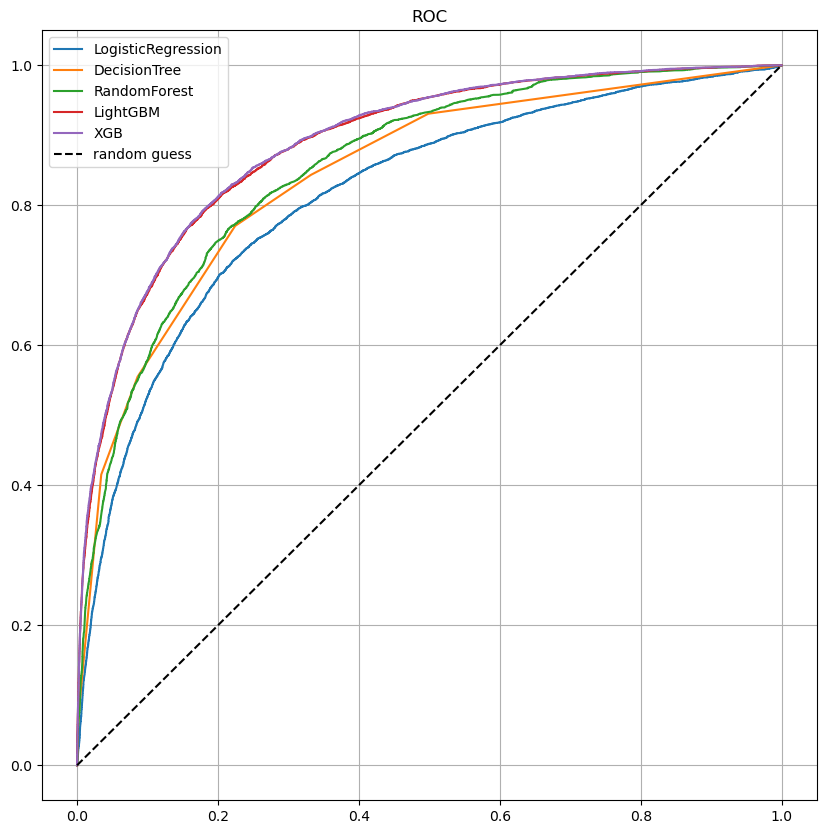

In [95]:
# class weight
draw_roc_curve(models, model_names, X_test, y_test)

- DecisionTree와 XGB를 제외하고 나머지 모델에서는 oversampling 없이 모델링 한 경우가 recall이 더 높았음 

---

# 최적의 파라미터값 구하기(GridSearchCV)

### 1. class weight + oversampling
하이퍼 파라미터 튜닝 진행
- recall 성능 좋았던 Decision Tree
- auc score 높았던 lgbm/xgb 

#### Decision Tree

In [73]:
params = {
    'max_depth': [3, 7, 10, 15, 20]
}

grid = GridSearchCV(dt_clf, param_grid=params, scoring='roc_auc', cv=3)
grid.fit(X_train_over, y_train_over)
dt_best = grid.best_estimator_


In [74]:
# best score 체크
print(f'grid.best_score: {grid.best_score_}')

# best params 체크
print(f'grid.best_params: {grid.best_params_}')

# test 데이터에서의 성능
print(f'accuracy score of test data: {accuracy_score(y_test, grid.best_estimator_.predict(X_test))}')

grid.best_score: 0.9406704400571769
grid.best_params: {'max_depth': 10}
accuracy score of test data: 0.8577921881155116


#### LightGBM

In [75]:
params = {
    'n_estimator' : [100, 300, 500],
    'learning_rate' : [0.05, 0.1],
    'max_depth' : [3, 7, 10, 20] 
}

grid = GridSearchCV(lgbm_clf, param_grid=params, cv=3, verbose=1, scoring='roc_auc', n_jobs=-1)
grid.fit(X_train_over, y_train_over)
lgbm_best = grid.best_estimator_


Fitting 3 folds for each of 24 candidates, totalling 72 fits


[LightGBM] [Warning] Unknown parameter: n_estimator
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: n_estimator
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 104112, number of negative: 104112
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041004 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1556
[LightGBM] [Info] Number of data points in the train set: 208224, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


In [76]:
# best score 체크
print(f'grid.best_score: {grid.best_score_}')

# best params 체크
print(f'grid.best_params: {grid.best_params_}')

# test 데이터에서의 성능
print(f'accuracy score of test data: {accuracy_score(y_test, grid.best_estimator_.predict(X_test))}')

grid.best_score: 0.9617434178281105
grid.best_params: {'learning_rate': 0.1, 'max_depth': 20, 'n_estimator': 100}
[LightGBM] [Warning] Unknown parameter: n_estimator
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
accuracy score of test data: 0.8617011605708917


#### XGB

In [77]:
params = {
    'n_estimator' : [100, 300, 500],
    'max_depth' : [3, 7, 10, 20] 
}

grid = GridSearchCV(xgb_clf, param_grid=params, cv=3, verbose=1, scoring='roc_auc', n_jobs=-1)
grid.fit(X_train_over, y_train_over)
xgb_best = grid.best_estimator_


Fitting 3 folds for each of 12 candidates, totalling 36 fits


c:\Users\User\miniconda3\envs\ds_study\lib\site-packages\xgboost\core.py:160: UserWarning: [12:29:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "n_estimator" } are not used.

  warnings.warn(smsg, UserWarning)


In [78]:
# best score 체크
print(f'grid.best_score: {grid.best_score_}')

# best params 체크
print(f'grid.best_params: {grid.best_params_}')

# test 데이터에서의 성능
print(f'accuracy score of test data: {accuracy_score(y_test, grid.best_estimator_.predict(X_test))}')

grid.best_score: 0.958403045160147
grid.best_params: {'max_depth': 3, 'n_estimator': 100}
accuracy score of test data: 0.8628223387170085


In [79]:
# 그리드서치 후 모델 성능 비교
models = [dt_best, lgbm_best, xgb_best]
model_names = ['DecisionTree', 'LightGBM', 'XGB']

results = get_result_pd(models, model_names, X_train_over, y_train_over, X_test, y_test)
results

==> Confusion matrix
[[23935  2042]
 [ 2651  4373]]
Accuracy : 0.8578, Precision : 0.6817
Recall : 0.6226, F1 : 0.6508, AUC : 0.8796
Fit time :  0.09486937522888184

[LightGBM] [Warning] Unknown parameter: n_estimator
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: n_estimator
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 104112, number of negative: 104112
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013384 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1556
[LightGBM] [Info] Number of data points in the train set: 208224, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: 

c:\Users\User\miniconda3\envs\ds_study\lib\site-packages\xgboost\core.py:160: UserWarning: [12:29:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "n_estimator" } are not used.

  warnings.warn(smsg, UserWarning)


==> Confusion matrix
[[24298  1679]
 [ 2848  4176]]
Accuracy : 0.8628, Precision : 0.7132
Recall : 0.5945, F1 : 0.6485, AUC : 0.8873
Fit time :  0.11825299263000488



,Accuracy,Precision,Recall,F1,Roc_Auc
DecisionTree,0.857792,0.681684,0.622580,0.650792,0.879560
LightGBM,0.861701,0.707210,0.597665,0.647840,0.888409
XGB,0.862822,0.713237,0.594533,0.648498,0.887282


[LightGBM] [Warning] Unknown parameter: n_estimator
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


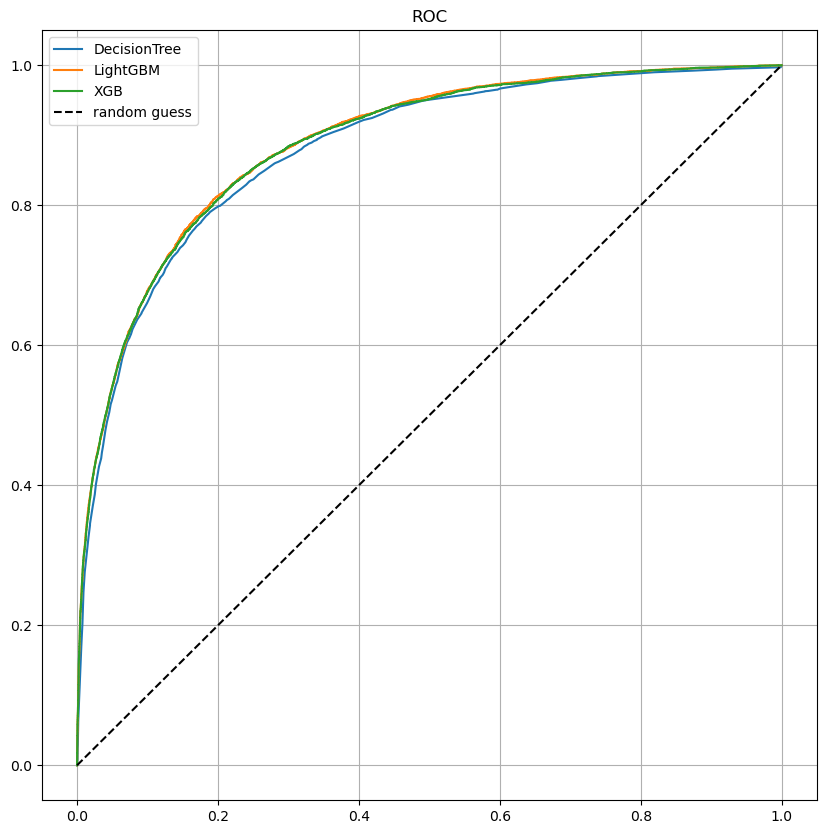

In [82]:
# roc 곡선 그리기
draw_roc_curve(models, model_names, X_test, y_test)

### 2. class weight
하이퍼 파라미터 튜닝 진행
- recall 성능 좋았던 lgbm
- auc score 높았던 xgb 


#### LightGBM

In [96]:
params = {
    'n_estimator' : [100, 300, 500],
    'learning_rate' : [0.05, 0.1],
    'max_depth' : [3, 7, 10, 20] 
}

grid = GridSearchCV(lgbm_clf, param_grid=params, cv=3, verbose=1, scoring='roc_auc', n_jobs=-1)
grid.fit(X_train, y_train)
lgbm_best = grid.best_estimator_


Fitting 3 folds for each of 24 candidates, totalling 72 fits
[LightGBM] [Warning] Unknown parameter: n_estimator
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: n_estimator
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 27891, number of negative: 104112
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002711 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 863
[LightGBM] [Info] Number of data points in the train set: 132003, number of used features: 13


In [97]:
# best score 체크
print(f'grid.best_score: {grid.best_score_}')

# best params 체크
print(f'grid.best_params: {grid.best_params_}')

# test 데이터에서의 성능
print(f'accuracy score of test data: {accuracy_score(y_test, grid.best_estimator_.predict(X_test))}')

grid.best_score: 0.8891731865232665
grid.best_params: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimator': 100}
[LightGBM] [Warning] Unknown parameter: n_estimator
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
accuracy score of test data: 0.8157934608042181


#### XGB

In [98]:
params = {
    'n_estimator' : [100, 300, 500],
    'max_depth' : [3, 7, 10, 20] 
}

grid = GridSearchCV(xgb_clf, param_grid=params, cv=3, verbose=1, scoring='roc_auc', n_jobs=-1)
grid.fit(X_train, y_train)
xgb_best = grid.best_estimator_


Fitting 3 folds for each of 12 candidates, totalling 36 fits


c:\Users\User\miniconda3\envs\ds_study\lib\site-packages\xgboost\core.py:160: UserWarning: [09:39:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "n_estimator" } are not used.

  warnings.warn(smsg, UserWarning)


In [99]:
# best score 체크
print(f'grid.best_score: {grid.best_score_}')

# best params 체크
print(f'grid.best_params: {grid.best_params_}')

# test 데이터에서의 성능
print(f'accuracy score of test data: {accuracy_score(y_test, grid.best_estimator_.predict(X_test))}')

grid.best_score: 0.8889098893904297
grid.best_params: {'max_depth': 3, 'n_estimator': 100}
accuracy score of test data: 0.8625193175964365


In [101]:
# 그리드서치 후 모델 성능 비교
models = [lgbm_best, xgb_best]
model_names = ['LightGBM', 'XGB']

results = get_result_pd(models, model_names, X_train, y_train, X_test, y_test)
results

[LightGBM] [Warning] Unknown parameter: n_estimator
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: n_estimator
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 27891, number of negative: 104112
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002213 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 863
[LightGBM] [Info] Number of data points in the train set: 132003, number of used features: 13
[LightGBM] [Warning] Unknown parameter: n_estimator
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown 

c:\Users\User\miniconda3\envs\ds_study\lib\site-packages\xgboost\core.py:160: UserWarning: [09:40:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "n_estimator" } are not used.

  warnings.warn(smsg, UserWarning)


==> Confusion matrix
[[24648  1329]
 [ 3208  3816]]
Accuracy : 0.8625, Precision : 0.7417
Recall : 0.5433, F1 : 0.6272, AUC : 0.8884
Fit time :  0.11170101165771484



,Accuracy,Precision,Recall,F1,Roc_Auc
LightGBM,0.815793,0.546520,0.79029,0.646179,0.888396
XGB,0.862519,0.741691,0.54328,0.627167,0.888350


[LightGBM] [Warning] Unknown parameter: n_estimator
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


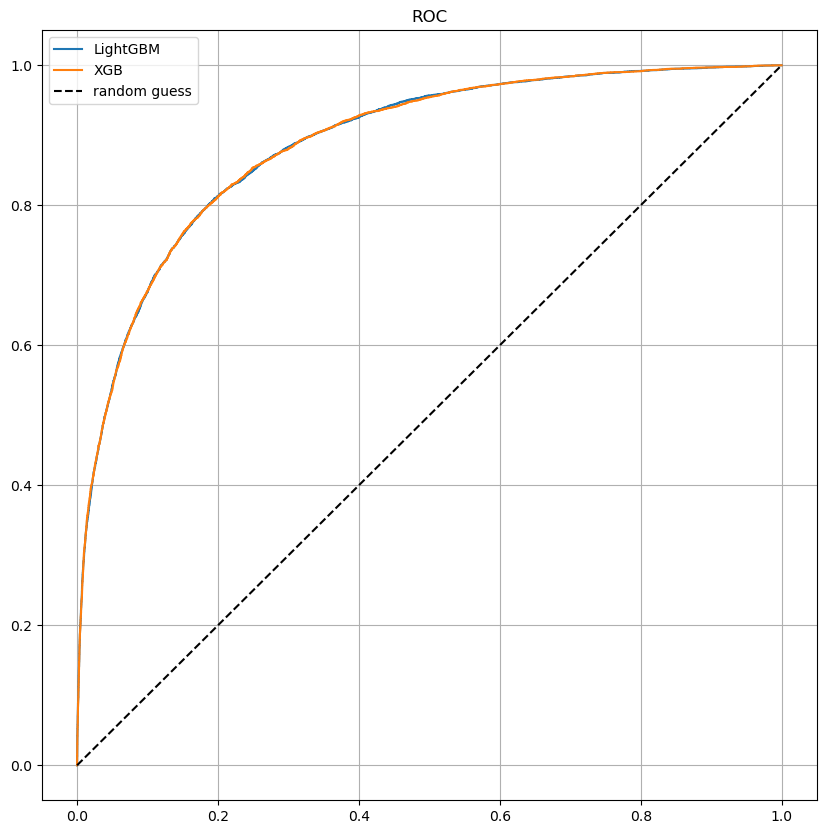

In [102]:
# roc 곡선 그리기
draw_roc_curve(models, model_names, X_test, y_test)

## 결과:
- Class weight만 포함시킨 모델의 하이퍼파라미터 튜닝 후 결과, lgbm의 recall 높아짐 / 반면에 XGB는 oversampling 없이 진행했기에 recall 값 떨어짐
- class weight + oversampling한 모델의 하이퍼파라미터 튜닝 후 결과, decision tree의 recall이 가장 높게나옴

---

# 중요 특성 파악하기

#### recall이 높은 decision tree

### oversampling

In [83]:
# 중요 특성 확인(영향력이 높은 feature들만 추려서 정렬)
best_cols_values = dt_best.feature_importances_
best_cols = pd.Series(best_cols_values, index=X_train_over.columns)
top_cols = best_cols.sort_values(ascending=False)
top_cols


NumOfProducts        0.380591
IsActiveMember       0.250262
Age                  0.168510
Gender_Male          0.063010
Gender_Female        0.045840
Balance              0.028693
Geography_Germany    0.025296
Geography_France     0.019933
Geography_Spain      0.008845
HasCrCard            0.005590
EstimatedSalary      0.001480
CreditScore          0.001411
Tenure               0.000540
dtype: float64

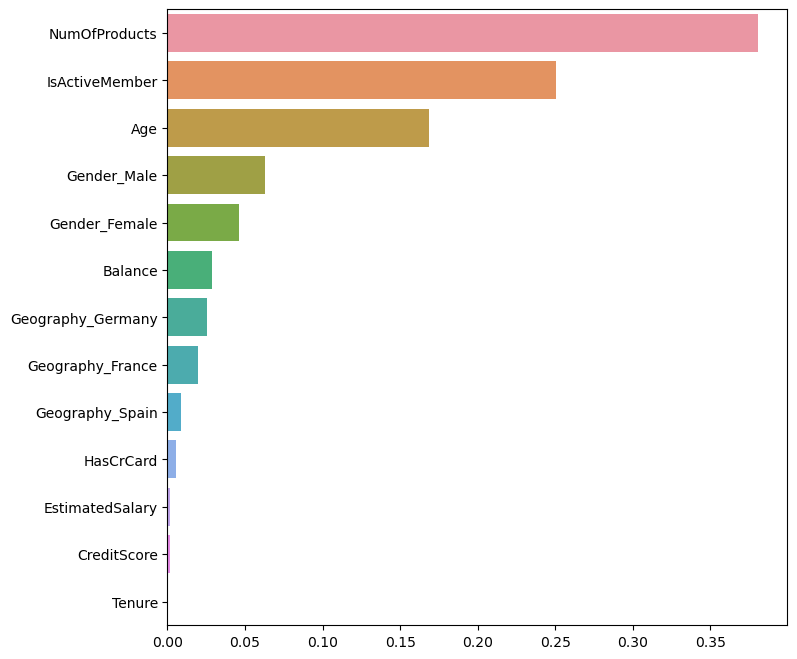

In [84]:
# 주요 특성 관찰
import seaborn as sns

plt.figure(figsize=(8,8))
sns.barplot(x=top_cols, y=top_cols.index)
plt.show()

In [ ]:
# # 주요 20개 특성만 가지고 다시 성능 확인
# X_train_re = X_train[top20_cols.index]
# X_test_re = X_test[top20_cols.index]

In [ ]:
# rf_clf_best_re = grid_cv.best_estimator_
# rf_clf_best_re.fit(X_train_re, y_train.values.reshape(-1,))

# pred1_re = rf_clf_best_re.predict(X_test_re)
# accuracy_score(y_test, pred1_re)

#### auc가 높은 lgbm

In [85]:
# 중요 특성 확인(영향력이 높은 feature들만 추려서 정렬)
best_cols_values = lgbm_best.feature_importances_
best_cols = pd.Series(best_cols_values, index=X_train_over.columns)
top_cols = best_cols.sort_values(ascending=False)
top_cols


Age                  825
Balance              357
NumOfProducts        273
EstimatedSalary      265
CreditScore          244
IsActiveMember       231
Geography_Germany    141
HasCrCard            140
Geography_France     125
Gender_Female        111
Gender_Male          104
Geography_Spain      101
Tenure                83
dtype: int32

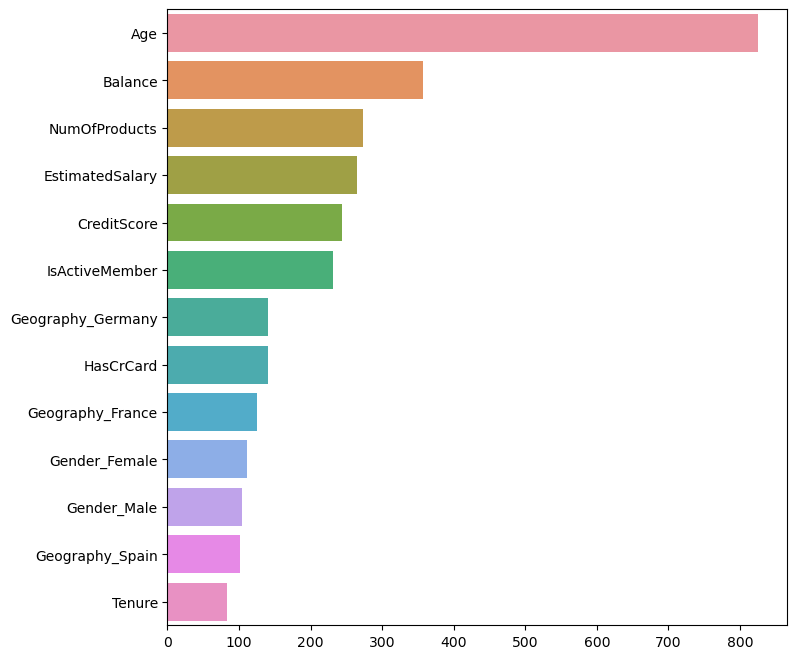

In [86]:
# 주요 특성 관찰
import seaborn as sns

plt.figure(figsize=(8,8))
sns.barplot(x=top_cols, y=top_cols.index)
plt.show()

### oversamplig 불포함

#### decision tree

In [103]:
# 중요 특성 확인(영향력이 높은 feature들만 추려서 정렬)
best_cols_values = dt_best.feature_importances_
best_cols = pd.Series(best_cols_values, index=X_train.columns)
top_cols = best_cols.sort_values(ascending=False)
top_cols


NumOfProducts        0.380591
IsActiveMember       0.250262
Age                  0.168510
Gender_Male          0.063010
Gender_Female        0.045840
Balance              0.028693
Geography_Germany    0.025296
Geography_France     0.019933
Geography_Spain      0.008845
HasCrCard            0.005590
EstimatedSalary      0.001480
CreditScore          0.001411
Tenure               0.000540
dtype: float64

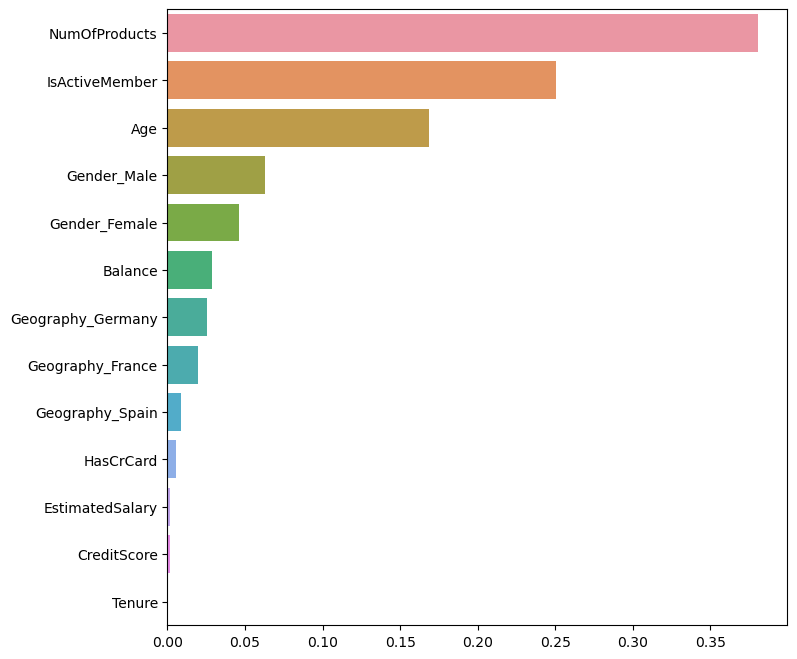

In [104]:
# 주요 특성 관찰
import seaborn as sns

plt.figure(figsize=(8,8))
sns.barplot(x=top_cols, y=top_cols.index)
plt.show()

#### lgbm

In [105]:
# 중요 특성 확인(영향력이 높은 feature들만 추려서 정렬)
best_cols_values = lgbm_best.feature_importances_
best_cols = pd.Series(best_cols_values, index=X_train.columns)
top_cols = best_cols.sort_values(ascending=False)
top_cols


Age                  547
Balance              521
CreditScore          483
EstimatedSalary      459
NumOfProducts        269
IsActiveMember       176
Tenure               153
Gender_Female        152
Geography_Germany    141
HasCrCard             64
Geography_France      20
Geography_Spain       15
Gender_Male            0
dtype: int32

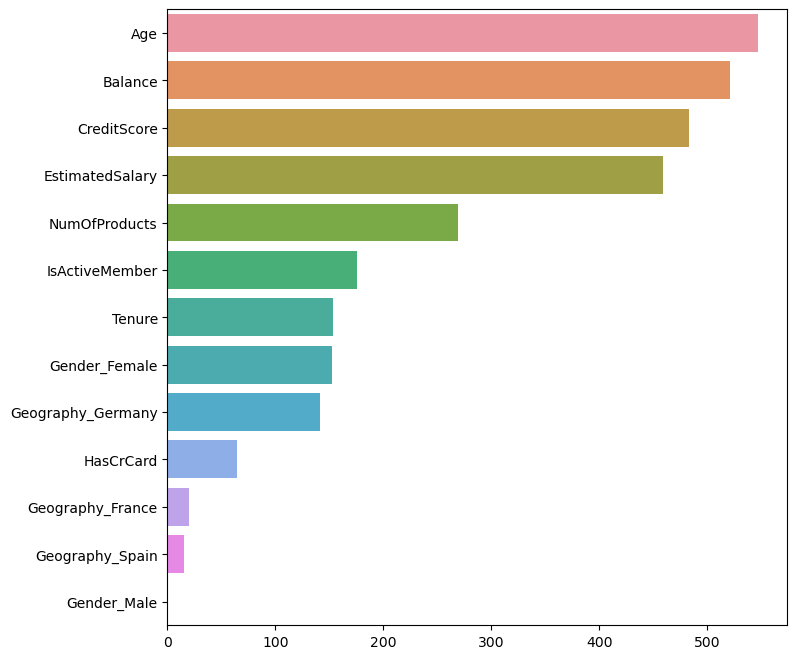

In [106]:
# 주요 특성 관찰
import seaborn as sns

plt.figure(figsize=(8,8))
sns.barplot(x=top_cols, y=top_cols.index)
plt.show()

# 결과:
- oversampling 여부에 따른 feature importance 순위변동 없음